In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
def clean_dataset(dataset):
    dataset.drop_duplicates()

    for i in range(dataset.columns.size):
        if (dataset[dataset.columns[i]].isnull().sum() and float(dataset[dataset.columns[i]].isnull().sum()) < dataset.shape[0]/90):
            dataset.dropna(subset=[dataset.columns[i]], inplace=True)

    dataset['Высота потолков, м'].fillna(2.65, inplace=True)
    dataset['Тип этажа'].fillna(
        dataset['Тип этажа'].mode().iloc[0], inplace=True)
    dataset['Состояние ремонта'].fillna('Нет', inplace=True)
    dataset.loc[dataset['Количество комнат']
                == 'Студия', 'Количество комнат'] = 0
    dataset['Дата снятия (продажи)'].fillna(np.nan, inplace=True)
    dataset['Школа\nм'].fillna(
        dataset['Школа\nм'].median(axis=0), inplace=True)
    dataset['Детский сад\nм'].fillna(
        dataset['Детский сад\nм'].median(axis=0), inplace=True)

    numdata = dataset.select_dtypes(include=["number"])
    for i in range(numdata.columns.size):
        dataset = dataset[
            (dataset[numdata.columns[i]] >= dataset[numdata.columns[i]].quantile(0.005)) & (dataset[numdata.columns[i]] <= dataset[numdata.columns[i]].quantile(0.995))]

    return dataset


In [25]:
def reform_data(dataset):
    for i in dataset.select_dtypes(include=[object]):
        if (dataset[i].unique().size > 2):
            dataset[i] = dataset[i].astype('category')
    dataset['Количество комнат'] = dataset['Количество комнат'].astype('int64')
    binary_columns = [
        i for i in dataset.columns if dataset[i].dtype.name == 'object']
    categorical_columns = [
        i for i in dataset.columns if dataset[i].dtype.name == 'category']
    numerical_columns = [i for i in dataset.columns if (
        dataset[i].dtype.name != 'category' and dataset[i].dtype.name != 'object')]

    binary_columns = ['Тип рынка', 'Парковка',
                      'Актуальность на дату послед. проверки']
    include_binary_columns = ['Тип рынка', 'Парковка']
    binary_columns = include_binary_columns
    data_binary = dataset[binary_columns]
    data_binary = data_binary.apply(lambda x: pd.factorize(x)[0])

    numerical_columns = ['Общая площадь,\nкв.м', 'Жилая площадь,\nкв.м', 'Площадь кухни,\nкв.м', 'Высота потолков, м', 'Год постройки', 'Этаж', 'Этажность', 'Количество комнат', 'Цена предложения,\nруб.',
                         'Удельная цена, руб./кв.м', 'Колич.  Просмотр.', 'Колич.  Просм. в день', 'Остановка\nм', 'Парк\nм', 'Центр\nкм', 'Станция метро\nм', 'Школа\nм', 'Детский сад\nм']
    include_numerical_columns = ['Общая площадь,\nкв.м', 'Этаж',
                                 'Остановка\nм', 'Парк\nм', 'Центр\nкм', 'Школа\nм', 'Детский сад\nм']
    numerical_columns = include_numerical_columns
    data_numerical = dataset[numerical_columns]

    categorical_columns = ['Функциональная зона', 'Тип дома', 'Класс', 'Тип этажа', 'Состояние ремонта',
                           'Материал стен', 'Дата создания', 'Дата парсинга', 'Дата послед. проверки', 'Дата снятия (продажи)']
    include_categorical_columns = ['Тип дома',
                                   'Класс', 'Тип этажа', 'Материал стен']
    categorical_columns = include_categorical_columns
    data_categorical = pd.get_dummies(
        dataset[categorical_columns], drop_first=True)

    data = pd.concat((data_binary, data_numerical, data_categorical,
                     dataset['Удельная цена, руб./кв.м']), axis=1)
    return data


### Те же действия что и раньше

In [26]:
df = pd.read_excel('apartment_data.xlsx',
                   usecols=lambda x: 'Unnamed' not in x, skiprows=1)
dataset = clean_dataset(df)
data = reform_data(dataset)

In [27]:
# index = data[data['Тип рынка'] == 0].index
# data.drop(index, inplace=True)
# data

In [28]:
from sklearn.model_selection import train_test_split

X = data.drop('Удельная цена, руб./кв.м', axis = 1)
y = data['Удельная цена, руб./кв.м']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1824, 19), (457, 19), (1824,), (457,))

### Линейная регрессия

In [29]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [30]:
coeff_linear = pd.DataFrame(regressor.coef_, X_train.columns, columns=['Coefficient'])
intercept_linear = regressor.intercept_
print(intercept_linear)
coeff_linear

147152.0984568675


,Coefficient
Тип рынка,-5832.816533
Парковка,1703.894279
"Общая площадь,\nкв.м",-326.431321
Этаж,1141.848596
Остановка\nм,-2.117097
Парк\nм,-2.940623
Центр\nкм,-2150.385143
Школа\nм,-3.631399
Детский сад\nм,-6.171068
Тип дома_Советская до 5 этажей вкл,-8128.257785


In [36]:
rows = coeff_linear.copy()
str = 'Класс'
k = [1]
b0 = intercept_linear

for i in rows.index:
    if (str not in i):
        rows.drop(i, inplace=True)

if (rows.index.size > 1):
    for i in range(rows.index.size):
        k.append((b0+rows.iloc[i][0])/b0)

    list = rows.index.to_list()
    list.insert(0, str + '_' +'Бизнес')
    corr = pd.DataFrame(index=list, columns=list)

    for i in range(corr.index.size):
        for j in range(corr.columns.size):
            corr.iloc[i][j] = k[i]/k[j]

if (rows.index.size == 1):
    for i in range(rows.index.size):
        k.append((b0+rows.iloc[i][0])/b0)

    list = ['Есть', 'Нет']
    corr = pd.DataFrame(index=list, columns=list)

    for i in range(corr.index.size):
        for j in range(corr.columns.size):
            corr.iloc[i][j] = k[i]/k[j]
corr

,Класс_Бизнес,Класс_Комфорт,Класс_Эконом,Класс_Элитный
Класс_Бизнес,1.0,1.146352,1.195176,0.883938
Класс_Комфорт,0.872333,1.0,1.042592,0.771088
Класс_Эконом,0.836697,0.959148,1.0,0.739588
Класс_Элитный,1.131301,1.296869,1.352104,1.0


In [457]:
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(y.shape, y_pred.shape)
df.head(10)

(2281,) (457,)


,Actual,Predicted
1923,148438,158387.189607
1768,104377,121033.537594
2167,106610,116343.618489
180,88838,107275.953137
2275,137281,145630.201398
81,139031,141760.317714
2543,104284,111559.868392
189,155877,103271.018594
1742,146970,160524.264351
674,129477,131889.827722


Считаю скорректированный коэффициент детерминации по этой формуле

In [458]:
def adjR(X, y):
    return 1 - (1-regressor.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

In [459]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Медиана абсолютной модели:', metrics.mean_absolute_error(y_test, y_pred)/y.mean())
print('Adjusted R-squared:', 1 - (1-regressor.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))

Mean Absolute Error: 19384.750459912702
Mean Squared Error: 734396535.2983663
Root Mean Squared Error: 27099.75157263192
Медиана абсолютной модели: 0.15883087434022264
Adjusted R-squared: 0.3336057654050367


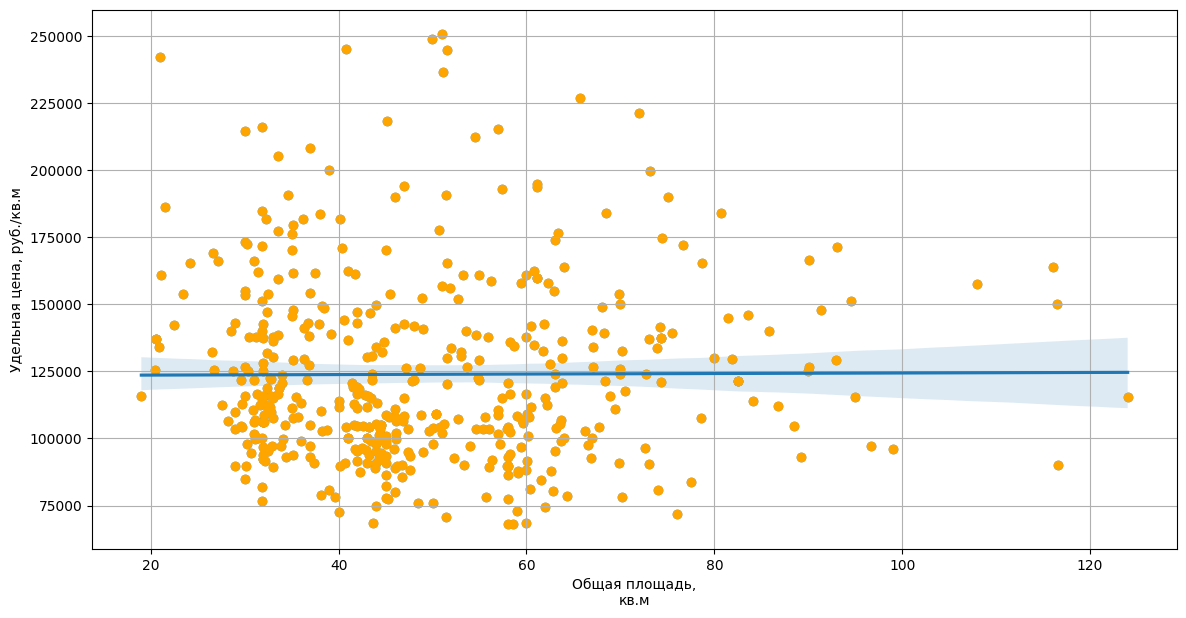

In [460]:
f, ax = plt.subplots(figsize=(14, 7))
sns.regplot(y=y_test, x=X_test['Общая площадь,\nкв.м'])
plt.scatter(X_test['Общая площадь,\nкв.м'], y_test, color="orange")
plt.grid(True)
plt.show()

### Полиномиальная регрессия

In [461]:
from sklearn.preprocessing import PolynomialFeatures

poly=PolynomialFeatures(degree=2)

pf_train = poly.fit_transform(X_train)
pf_test = poly.fit_transform(X_test)

X = pf_train
y = y_train

pfregressor = LinearRegression()
pfregressor.fit(pf_train, y_train)

LinearRegression()

In [462]:
y_pred = pfregressor.predict(pf_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(y_test.shape, y_pred.shape)
df.head(10)

(457,) (457,)


,Actual,Predicted
1923,148438,176876.021874
1768,104377,117635.701637
2167,106610,112934.167056
180,88838,106605.193570
2275,137281,148395.461621
81,139031,131782.505456
2543,104284,98943.630798
189,155877,96300.875716
1742,146970,157773.831056
674,129477,123661.822983


In [463]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Медиана абсолютной модели:', metrics.mean_absolute_error(y_test, y_pred)/y.mean())
print('Adjusted R-squared:', 1 - (1-pfregressor.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))

Mean Absolute Error: 18317.815650681645
Mean Squared Error: 660098451.6099961
Root Mean Squared Error: 25692.381197740237
Медиана абсолютной модели: 0.15064769131209496
Adjusted R-squared: 0.3784775774455206


In [464]:
pfregressor.coef_

array([ 1.75240810e-06, -1.04583138e+04, -1.70689462e+03, -2.69488634e+02,
        1.84481169e+03, -1.75384065e+02, -1.21637898e+01, -3.32326248e+03,
        2.15535577e+01,  2.97290868e+01, -3.85322930e+03,  1.22049715e+04,
       -1.88052018e+00, -7.80151678e-01,  3.99392734e-02, -4.70856810e+03,
        1.30795879e+03, -2.61460001e+03,  2.40465880e+03,  2.10585529e+02,
       -1.04583138e+04, -2.22464258e+03, -1.37366655e+02,  1.28442954e+03,
       -3.95853115e+01,  1.59805655e+01,  1.07696099e+03,  3.93106562e+01,
        1.95567570e+00,  9.09973672e+03,  5.74591037e+03,  4.97326449e-02,
       -1.04599981e+04, -4.49473703e-09, -1.40314822e+04, -5.86203621e+03,
        5.62905459e+03, -1.52317329e+04, -8.55635479e+02, -1.70689463e+03,
        1.36909823e+02,  3.56213393e+02, -1.03006433e+01,  9.68476925e-01,
       -1.42105134e+02, -1.76666988e+00,  7.86994141e+00, -3.99641067e+02,
       -6.60250203e+03, -2.77323670e+00, -1.70579598e+03,  3.99396353e-02,
       -1.83249312e+03,  

In [465]:
coeff_linear = pd.DataFrame(pf_test, columns = poly.get_feature_names_out())
coeff_linear

,1,Тип рынка,Парковка,"Общая площадь,\nкв.м",Этаж,Остановка\nм,Парк\nм,Центр\nкм,Школа\nм,Детский сад\nм,...,Тип этажа_Средний^2,Тип этажа_Средний Материал стен_Кирпичный,Тип этажа_Средний Материал стен_Монолитный,Тип этажа_Средний Материал стен_Панельный,Материал стен_Кирпичный^2,Материал стен_Кирпичный Материал стен_Монолитный,Материал стен_Кирпичный Материал стен_Панельный,Материал стен_Монолитный^2,Материал стен_Монолитный Материал стен_Панельный,Материал стен_Панельный^2
0,1.0,1.0,1.0,38.400002,8.0,94.0,2332.0,7.0,301.0,244.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,29.700001,2.0,87.0,1037.0,9.0,495.0,420.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,46.900002,1.0,443.0,833.0,3.0,579.0,334.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,43.900002,5.0,234.0,805.0,8.0,180.0,149.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,74.300003,4.0,206.0,480.0,5.0,244.0,284.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452,1.0,0.0,1.0,33.000000,1.0,111.0,663.0,13.0,240.0,347.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
453,1.0,0.0,0.0,29.000000,1.0,317.0,788.0,7.0,113.0,731.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
454,1.0,1.0,1.0,50.799999,2.0,758.0,925.0,6.0,707.0,630.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
455,1.0,1.0,1.0,84.099998,1.0,243.0,2235.0,7.0,301.0,244.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


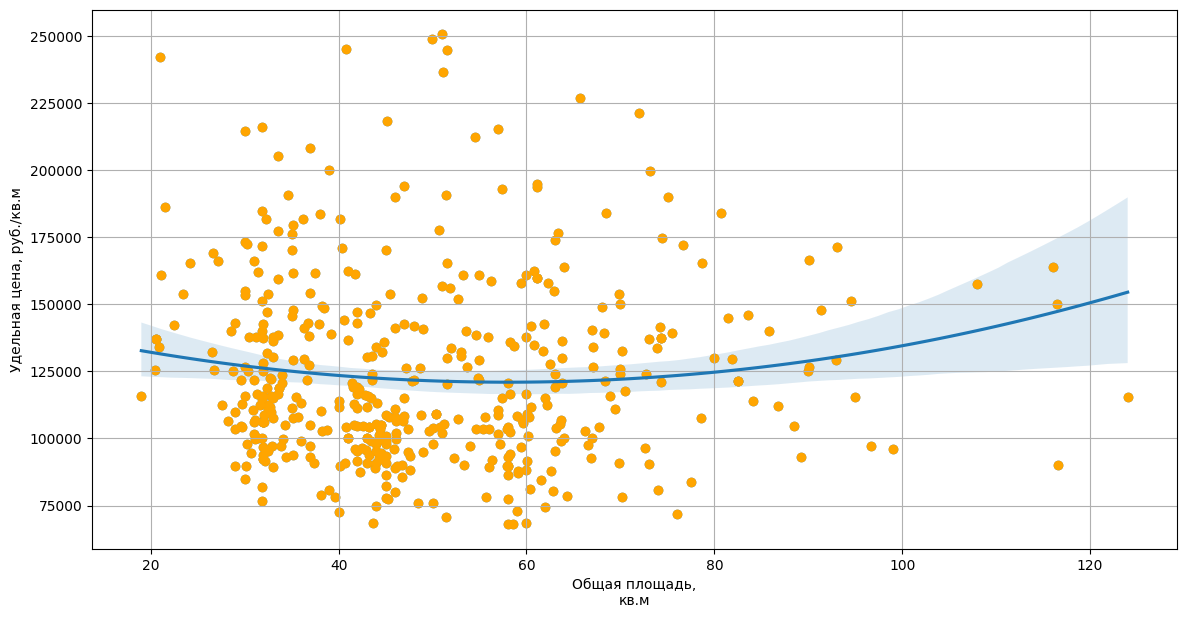

In [466]:
degree = 2
f, ax = plt.subplots(figsize=(14, 7))
sns.regplot(y=y_test, x=X_test['Общая площадь,\nкв.м'], order=degree)
plt.scatter(X_test['Общая площадь,\nкв.м'], y_test, color="orange")
plt.grid(True)
plt.show()